In [27]:
import os
import os.path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms,models
from torchvision.transforms import Resize, ToTensor, Normalize

from tqdm import tqdm

In [4]:
!pip install timm

## 데이터 class별 분류

In [5]:
# train dataset 있는 곳
train_path = '/opt/ml/input/data/train' 

In [6]:
# os.path.join() 함수를 사용하여 '/opt/ml/input/data/train' 와 'train.csv' 를 연결해서 '/opt/ml/input/data/train/train.csv' 경로 생성
train_data = pd.read_csv(os.path.join(train_path,'train_data.csv'))
print(train_data["path"].head(5))
print('-'*50)
print(train_data.head(5))

0    /opt/ml/input/data/train/images/003013_female_...
1    /opt/ml/input/data/train/images/003013_female_...
2    /opt/ml/input/data/train/images/003013_female_...
3    /opt/ml/input/data/train/images/003013_female_...
4    /opt/ml/input/data/train/images/003013_female_...
Name: path, dtype: object
--------------------------------------------------
   id  gender  age       mask  class  \
0   1  female   19       mask      3   
1   2  female   19  incorrect      9   
2   3  female   19       mask      3   
3   4  female   19       mask      3   
4   5  female   19       mask      3   

                                                path  
0  /opt/ml/input/data/train/images/003013_female_...  
1  /opt/ml/input/data/train/images/003013_female_...  
2  /opt/ml/input/data/train/images/003013_female_...  
3  /opt/ml/input/data/train/images/003013_female_...  
4  /opt/ml/input/data/train/images/003013_female_...  


In [7]:
print(train_data["path"][1])
print(train_data["path"][1].split("/")[-2].split("_")[1]) # 성별
print(train_data["path"][1].split("/")[-2].split("_")[3]) # 나이
print(train_data["path"][100].split("/")[-1].split(".")[0]) # 마스크 착용 유무

/opt/ml/input/data/train/images/003013_female_Asian_19/incorrect_mask.jpg
female
19
mask3


/opt/ml/input/data/train/images/003013_female_Asian_19/mask1.jpg
1
0
0
/opt/ml/input/data/train/images/001450_female_Asian_50/mask5.jpg
1
1
0


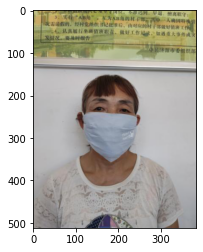

In [8]:
# 각각 레이블 분리
d_path = '/opt/ml/input/data/train/images'
train_path = []
train_gender_label = []
train_age_label = []
train_mask_label = []
for p in train_data["path"]:
    # 경로
    train_path.append(p)
    
    # 성별
    if p.split("/")[-2].split("_")[1] == 'female':
        train_gender_label.append(1) # 여자 1
    else:
        train_gender_label.append(0) # 남자 0
        
    # 마스크
    if 'incorrect' in p.split("/")[-1].split(".")[0]:
        train_mask_label.append(2) # 턱스크 2
    elif 'normal' in p.split("/")[-1].split(".")[0]:
        train_mask_label.append(1) # 안쓴경우 1
    else:
        train_mask_label.append(0) # 쓴경우
    
    # 나이 30세이하 : 0, 30~60 : 1, 60세이상 : 2 
    if int(p.split("/")[-2].split("_")[3]) < 30:
        train_age_label.append(0)
    elif 30 <= int(p.split("/")[-2].split("_")[3]) < 60:
        train_age_label.append(1)
    else:
        train_age_label.append(2)
        
        
print(train_path[0])     
print(train_gender_label[0])
print(train_age_label[0])
print(train_mask_label[0])

print(train_path[8326])     
print(train_gender_label[8326])
print(train_age_label[8326])
print(train_mask_label[8326])


plt.imshow(Image.open(train_path[8326]))

# # 006664_male_Asian_19 -> 성별, 나이
# for p in train_data["path"]:
#     _,gender,_,age = p.split('_')
#     path = os.path.join(d_path,p)
#     num = 0
#     if (int(age) >= 30) & (int(age) < 60):
#         num += 1
#     elif int(age) >= 60:
#         num += 2
    
#     if gender == 'female':
#         num += 3
# ####### num이 어떤식으로 쓰이는지 모르겠네.. , +6하고 +12도

#     for s in glob.glob(path + '/*'):
#         name = s.split(os.sep)[-1]
#         if name.find('incorrect') == 0:
#             train_path.append(os.path.join(path, name))
#             train_label.append(num+6)
#         elif name.find('mask') == 0:
#             train_path.append(os.path.join(path, name))
#             train_label.append(num)
#         elif name.find('normal') == 0:
#             train_path.append(os.path.join(path, name))
#             train_label.append(num+12)

# #######
# # 이미지주소랑 그에 대응되는 라벨
# print(train_path[0])
# print(train_label[0])
# print(len(train_path))
# plt.imshow(Image.open(train_path[0]))

## 모델 불러오기

In [9]:
import timm
gender_model = timm.create_model('resnet50', pretrained=False, num_classes=2)
age_model = timm.create_model('resnet50', pretrained=False, num_classes=3)
mask_model = timm.create_model('resnet50', pretrained=False, num_classes=3)

## trainset

In [10]:
class Traindataset(Dataset):
    def __init__(self,images,labels,transform):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        if not self.transform == None:
            image = self.transform(Image.open(self.images[idx])) # 경로를 이미지로 바꾸고 transform 적용
        return image, self.labels[idx] # 이미지랑, 라벨이랑 같이 리턴

In [11]:
# transform
transform = transforms.Compose([
    transforms.Resize((224,224),Image.BILINEAR), # image net으로 pretrained # 이미지 줄어들때 부드럽게 만들어주는 효과
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(), # 텐서로 바꿔주고
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)) ]) # 정규화
    

In [12]:
from sklearn.model_selection import train_test_split
# 성별 데이터셋
# train dataset,dataloader 구성
gender_train_dataset = Traindataset(train_path,train_gender_label, transform) # 이미지경로, label
gender_trainset, gender_valset = train_test_split(gender_train_dataset, test_size=0.2, random_state=42)

gender_train_dataloader = DataLoader(gender_trainset, batch_size=64, shuffle=True)
gender_val_dataloader = DataLoader(gender_valset, batch_size=64, shuffle=False)


In [13]:
# 나이 데이터셋
# train dataset,dataloader 구성
age_train_dataset = Traindataset(train_path,train_age_label, transform) # 이미지경로, label
age_trainset, age_valset = train_test_split(age_train_dataset, test_size=0.2, random_state=42)

age_train_dataloader = DataLoader(age_trainset, batch_size=64, shuffle=True)
age_val_dataloader = DataLoader(age_valset, batch_size=64, shuffle=False)


In [14]:
# 마스크 데이터셋
# train dataset,dataloader 구성
mask_train_dataset = Traindataset(train_path,train_mask_label, transform) # 이미지경로, label
mask_trainset, mask_valset = train_test_split(mask_train_dataset, test_size=0.2, random_state=42)

mask_train_dataloader = DataLoader(mask_trainset, batch_size=64, shuffle=True)
mask_val_dataloader = DataLoader(gender_valset, batch_size=64, shuffle=False)



In [15]:
next(iter(gender_train_dataloader))

[tensor([[[[ 1.6961,  1.6961,  1.6961,  ...,  1.2843,  1.2647,  1.2647],
           [ 1.6765,  1.6765,  1.6765,  ...,  1.2843,  1.2647,  1.2647],
           [ 1.6765,  1.6765,  1.6765,  ...,  1.2843,  1.2647,  1.2647],
           ...,
           [-0.7941, -0.6373, -0.2647,  ..., -0.7549, -0.9510, -1.0686],
           [-0.7745, -0.8333, -0.6765,  ..., -1.0294, -1.1275, -1.0490],
           [-0.7941, -0.9706, -0.9118,  ..., -1.2451, -1.1667, -1.0882]],
 
          [[ 1.4804,  1.4804,  1.4804,  ...,  1.0294,  1.0098,  1.0098],
           [ 1.4804,  1.4804,  1.4804,  ...,  1.0294,  1.0098,  1.0098],
           [ 1.4608,  1.4608,  1.4608,  ...,  1.0294,  1.0098,  1.0098],
           ...,
           [-0.8529, -0.7157, -0.3431,  ..., -0.5588, -0.7157, -0.7745],
           [-0.8333, -0.8922, -0.7549,  ..., -1.0098, -1.0882, -0.9706],
           [-0.8529, -1.0294, -0.9902,  ..., -1.2647, -1.1863, -1.0882]],
 
          [[ 1.2451,  1.2451,  1.2451,  ...,  0.7941,  0.7745,  0.7745],
           [ 

In [16]:
next(iter(gender_val_dataloader))

[tensor([[[[ 0.5392,  0.5588,  0.5784,  ...,  0.5588,  0.5392,  0.5392],
           [ 0.5588,  0.5588,  0.5784,  ...,  0.5784,  0.5588,  0.5588],
           [ 0.5784,  0.5980,  0.5980,  ...,  0.6176,  0.5980,  0.5980],
           ...,
           [-1.2451, -1.2451, -1.2255,  ..., -1.2843, -1.3039, -1.3039],
           [-1.2255, -1.2059, -1.1863,  ..., -1.1275, -1.1471, -1.1667],
           [-1.2059, -1.2059, -1.1863,  ..., -1.1078, -1.1275, -1.1471]],
 
          [[ 0.7745,  0.7941,  0.7941,  ...,  0.7941,  0.7745,  0.7745],
           [ 0.7941,  0.7941,  0.8137,  ...,  0.7941,  0.7941,  0.7941],
           [ 0.8137,  0.8137,  0.8137,  ...,  0.8333,  0.8137,  0.8137],
           ...,
           [-1.2451, -1.2451, -1.2255,  ..., -1.2843, -1.3039, -1.3039],
           [-1.2255, -1.2059, -1.1863,  ..., -1.1275, -1.1471, -1.1667],
           [-1.2059, -1.2059, -1.1863,  ..., -1.1078, -1.1275, -1.1471]],
 
          [[ 0.7549,  0.7549,  0.7745,  ...,  0.7353,  0.7157,  0.7157],
           [ 

In [17]:
import timm
gender_model = timm.create_model('resnet50', pretrained=True, num_classes=2)
age_model = timm.create_model('resnet50', pretrained=True, num_classes=3)
mask_model = timm.create_model('resnet50', pretrained=True, num_classes=3)

In [18]:
# gender model

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# loss함수, optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gender_model.parameters(), lr=1e-3)
gender_model = gender_model.to(device)
# checkpoint 만들어주기
os.makedirs("pre_aug_gender_check_point_5epoch", exist_ok=True)

In [19]:
# gender train code
log_loss = []
log_acc = []

for epoch in range(1,6):
    gender_model.train()
    with tqdm(gender_train_dataloader) as pbar:
        pbar.set_description(f"Epoch : {epoch}")
        sum_loss = 0
        sum_acc = 0
        sum_len = 0
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            pred = gender_model(imgs)
            _, pred_idx = torch.max(pred, dim=1)
            loss = criterion(pred, labels)
            
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            sum_acc += torch.sum(pred_idx == labels).item()
            sum_len += imgs.size(0)
            
            pbar.set_postfix(train_loss=f"{sum_loss / sum_len:.3f}", train_acc=f"{sum_acc / sum_len:.3f}")
            
        log_loss = sum_loss / sum_len
        log_acc = sum_acc / sum_len
            
    if epoch % 5 == 0:
        torch.save(gender_model.state_dict(), "pre_aug_gender_check_point_5epoch/model_" + str(epoch) + ".pth")

Epoch : 5: 100%|██████████| 237/237 [00:51<00:00,  4.60it/s, train_acc=0.997, train_loss=0.000]


In [20]:
# gender_validation으로 정확도 평가
gender_model.eval()
val_acc = 0

with torch.no_grad():
    for inputs, labels in gender_val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = gender_model(inputs)
        preds = outputs.argmax(dim=1)
        val_acc += (preds == labels).float().sum()
    
    val_acc /= len(gender_valset)
    print('Gender Validation Accuracy: {:.3f}'.format(val_acc))

Gender Validation Accuracy: 0.990


In [21]:
# age model

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# loss함수, optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(age_model.parameters(), lr=1e-3)
age_model = age_model.to(device)
# checkpoint 만들어주기
os.makedirs("pre_aug_age_check_point_5epoch", exist_ok=True)

In [22]:
# age train code
log_loss = []
log_acc = []

for epoch in range(1,6):
    age_model.train()
    with tqdm(age_train_dataloader) as pbar:
        pbar.set_description(f"Epoch : {epoch}")
        sum_loss = 0
        sum_acc = 0
        sum_len = 0
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            pred = age_model(imgs)
            _, pred_idx = torch.max(pred, dim=1)
            loss = criterion(pred, labels)
            
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            sum_acc += torch.sum(pred_idx == labels).item()
            sum_len += imgs.size(0)
            
            pbar.set_postfix(train_loss=f"{sum_loss / sum_len:.3f}", train_acc=f"{sum_acc / sum_len:.3f}")
            
        log_loss = sum_loss / sum_len
        log_acc = sum_acc / sum_len
            
    if epoch % 5 == 0:
        torch.save(age_model.state_dict(), "pre_aug_age_check_point_5epoch/model_" + str(epoch) + ".pth")

Epoch : 5: 100%|██████████| 237/237 [00:51<00:00,  4.57it/s, train_acc=0.991, train_loss=0.000]


In [23]:
# age_validation으로 정확도 평가
age_model.eval()
val_acc = 0

with torch.no_grad():
    for inputs, labels in age_val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = age_model(inputs)
        preds = outputs.argmax(dim=1)
        val_acc += (preds == labels).float().sum()
        print(preds)
        print(labels)
    
    val_acc /= len(age_valset)
    print('Age Gender Validation Accuracy: {:.3f}'.format(val_acc))

tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2], device='cuda:0')
tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 2], device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,

In [24]:
# mask model

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# loss함수, optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mask_model.parameters(), lr=1e-3)
mask_model = mask_model.to(device)
# checkpoint 만들어주기
os.makedirs("pre_aug_mask_check_point_5epoch", exist_ok=True)

In [25]:
# mask train code
log_loss = []
log_acc = []

for epoch in range(1,6):
    mask_model.train()
    with tqdm(mask_train_dataloader) as pbar:
        pbar.set_description(f"Epoch : {epoch}")
        sum_loss = 0
        sum_acc = 0
        sum_len = 0
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            pred = mask_model(imgs)
            _, pred_idx = torch.max(pred, dim=1)
            loss = criterion(pred, labels)
            
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            sum_acc += torch.sum(pred_idx == labels).item()
            sum_len += imgs.size(0)
            
            pbar.set_postfix(train_loss=f"{sum_loss / sum_len:.3f}", train_acc=f"{sum_acc / sum_len:.3f}")
            
        log_loss = sum_loss / sum_len
        log_acc = sum_acc / sum_len
            
    if epoch % 5 == 0:
        torch.save(age_model.state_dict(), "pre_aug_mask_check_point_5epoch/model_" + str(epoch) + ".pth")

Epoch : 5: 100%|██████████| 237/237 [00:52<00:00,  4.56it/s, train_acc=0.996, train_loss=0.000]


In [26]:
# mask_validation으로 정확도 평가
mask_model.eval()
val_acc = 0

with torch.no_grad():
    for inputs, labels in mask_val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = mask_model(inputs)
        preds = outputs.argmax(dim=1)
        val_acc += (preds == labels).float().sum()
    
    val_acc /= len(age_valset)
    print('Mask Gender Validation Accuracy: {:.3f}'.format(val_acc))

Mask Gender Validation Accuracy: 0.361


In [36]:
# train code
log_loss = []
log_acc = []

for epoch in range(1,31):
    model.train()
    with tqdm(train_dataloader) as pbar:
        pbar.set_description(f"Epoch : {epoch}")
        sum_loss = 0
        sum_acc = 0
        sum_len = 0
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            pred = model(imgs)
            _, pred_idx = torch.max(pred, dim=1)
            loss = criterion(pred, labels)
            
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()
            sum_acc += torch.sum(pred_idx == labels).item()
            sum_len += imgs.size(0)
            
            pbar.set_postfix(train_loss=f"{sum_loss / sum_len:.3f}", train_acc=f"{sum_acc / sum_len:.3f}")
            
        log_loss = sum_loss / sum_len
        log_acc = sum_acc / sum_len
            
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "check_point/model_" + str(epoch) + ".pth")

Epoch : 1:   0%|          | 0/296 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 31.75 GiB total capacity; 20.24 GiB already allocated; 74.50 MiB free; 20.37 GiB reserved in total by PyTorch)